# Logistic Regression for Breast Cancer Diagnosis

This notebook implements a logistic regression model to classify breast cancer tumors as malignant or benign using the Wisconsin Diagnostic Breast Cancer (WDBC) dataset.

## Dataset Information
- **Instances**: 569 samples
- **Features**: 30 real-valued features computed from breast mass images
- **Target**: Diagnosis (M = malignant, B = benign)
- **Class distribution**: 357 benign, 212 malignant
- **Missing values**: None

The features describe characteristics of cell nuclei such as radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, and fractal dimension.


In [1]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn


  Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached scipy-1.15.3-cp310-cp310-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 32.7 MB/s eta 0:00:00 0:00:01
Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl (5.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 32.4 MB/s eta 0:00:00a 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")


✅ All libraries imported successfully!
📊 Ready to build logistic regression model for breast cancer diagnosis


##  Data Loading


In [3]:
# Define feature names based on the dataset description
feature_names = [
    'id', 'diagnosis',
    # Mean features (3-12)
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    # SE features (13-22)
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    # Worst features (23-32)
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

# Load the dataset
data_path = '../datasets/breast+cancer+wisconsin+diagnostic/wdbc.data'
df = pd.read_csv(data_path, header=None, names=feature_names)

print(f" Dataset shape: {df.shape}")
print(f" Features: {len(feature_names) - 2} (excluding ID and diagnosis)")
print(f" Samples: {len(df)}")

# Display first 5 rows
print("\n First 5 rows:")
df.head()


 Dataset shape: (569, 32)
 Features: 30 (excluding ID and diagnosis)
 Samples: 569

 First 5 rows:


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


##  Data Exploration


In [4]:
# Basic dataset information
print("="*50)
print(" DATASET OVERVIEW")
print("="*50)

print(f"Dataset shape: {df.shape}")
print(f"Number of features: {len(df.columns) - 2}")  # Excluding ID and diagnosis
print(f"Number of samples: {len(df)}")

print("\n Data Types:")
print(df.dtypes.value_counts())

print("\n Dataset Info:")
df.info()


 DATASET OVERVIEW
Dataset shape: (569, 32)
Number of features: 30
Number of samples: 569

 Data Types:
float64    30
int64       1
object      1
Name: count, dtype: int64

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  f

In [5]:
# Check for missing values
print("="*50)
print(" MISSING VALUES CHECK")
print("="*50)

missing_values = df.isnull().sum()
total_missing = missing_values.sum()

print(f"Total missing values: {total_missing}")

if total_missing > 0:
    print("Missing values per column:")
    print(missing_values[missing_values > 0])
else:
    print(" No missing values found!")

# Basic statistical summary
print("\n="*50)
print(" STATISTICAL SUMMARY")
print("="*50)

# Get only numeric columns (excluding ID and diagnosis)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in numeric_cols:
    numeric_cols.remove('id')

print(f"Numeric features: {len(numeric_cols)}")
print("\nBasic statistics:")
df[numeric_cols].describe().round(3)


 MISSING VALUES CHECK
Total missing values: 0
 No missing values found!

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
 STATISTICAL SUMMARY
Numeric features: 30

Basic statistics:


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,14.127,19.290,91.969,654.889,0.096,0.104,0.089,0.049,0.181,0.063,...,16.269,25.677,107.261,880.583,0.132,0.254,0.272,0.115,0.290,0.084
std,3.524,4.301,24.299,351.914,0.014,0.053,0.080,0.039,0.027,0.007,...,4.833,6.146,33.603,569.357,0.023,0.157,0.209,0.066,0.062,0.018
min,6.981,9.710,43.790,143.500,0.053,0.019,0.000,0.000,0.106,0.050,...,7.930,12.020,50.410,185.200,0.071,0.027,0.000,0.000,0.156,0.055
25%,11.700,16.170,75.170,420.300,0.086,0.065,0.030,0.020,0.162,0.058,...,13.010,21.080,84.110,515.300,0.117,0.147,0.114,0.065,0.250,0.071
50%,13.370,18.840,86.240,551.100,0.096,0.093,0.062,0.034,0.179,0.062,...,14.970,25.410,97.660,686.500,0.131,0.212,0.227,0.100,0.282,0.080
75%,15.780,21.800,104.100,782.700,0.105,0.130,0.131,0.074,0.196,0.066,...,18.790,29.720,125.400,1084.000,0.146,0.339,0.383,0.161,0.318,0.092
max,28.110,39.280,188.500,2501.000,0.163,0.345,0.427,0.201,0.304,0.097,...,36.040,49.540,251.200,4254.000,0.223,1.058,1.252,0.291,0.664,0.208


In [6]:
# Target variable analysis
print("="*50)
print(" TARGET VARIABLE ANALYSIS")
print("="*50)

# Count of each diagnosis
diagnosis_counts = df['diagnosis'].value_counts()
print("Diagnosis distribution:")
print(diagnosis_counts)

print(f"\nPercentage distribution:")
print(f"Benign (B): {diagnosis_counts['B'] / len(df) * 100:.1f}%")
print(f"Malignant (M): {diagnosis_counts['M'] / len(df) * 100:.1f}%")

# Check class balance
total_samples = len(df)
minority_class = min(diagnosis_counts['B'], diagnosis_counts['M'])
majority_class = max(diagnosis_counts['B'], diagnosis_counts['M'])
imbalance_ratio = minority_class / majority_class

print(f"\nClass balance:")
print(f"Minority class: {minority_class} samples")
print(f"Majority class: {majority_class} samples")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 0.8:
    print(" Dataset is well balanced")
elif imbalance_ratio > 0.5:
    print(" Dataset has mild imbalance")
else:
    print(" Dataset has significant imbalance")


 TARGET VARIABLE ANALYSIS
Diagnosis distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64

Percentage distribution:
Benign (B): 62.7%
Malignant (M): 37.3%

Class balance:
Minority class: 212 samples
Majority class: 357 samples
Imbalance ratio: 0.59
 Dataset has mild imbalance


 DATA VISUALIZATION


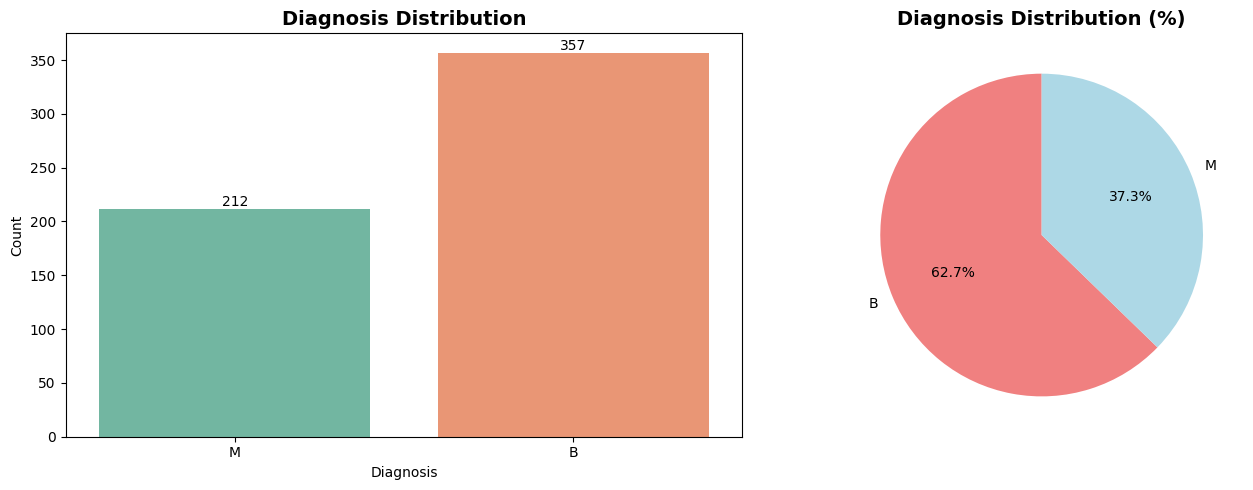

✅ Basic data exploration completed!


In [ ]:
# Basic visualizations
print("="*50)
print(" DATA VISUALIZATION")
print("="*50)

# Create subplots for target variable visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='diagnosis', ax=axes[0], palette='Set2')
axes[0].set_title('Diagnosis Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diagnosis')
axes[0].set_ylabel('Count')

# Add count labels on bars
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom')

# Pie chart
diagnosis_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                     startangle=90, colors=['lightcoral', 'lightblue'])
axes[1].set_title('Diagnosis Distribution (%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(" Basic data exploration completed!")


In [ ]:
# Feature group analysis
print("="*50)
print(" FEATURE GROUPS ANALYSIS")
print("="*50)

# Group features by type
feature_columns = df.drop(['id', 'diagnosis'], axis=1).columns
mean_features = [col for col in feature_columns if 'mean' in col]
se_features = [col for col in feature_columns if 'se' in col]
worst_features = [col for col in feature_columns if 'worst' in col]

print(f"Total features: {len(feature_columns)}")
print(f"Mean features: {len(mean_features)}")
print(f"SE features: {len(se_features)}")
print(f"Worst features: {len(worst_features)}")

print(f"\nMean features: {mean_features}")
print(f"\nSE features: {se_features}")
print(f"\nWorst features: {worst_features}")




🔬 FEATURE GROUPS ANALYSIS
Total features: 30
Mean features: 10
SE features: 10
Worst features: 10

Mean features: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean']

SE features: ['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se']

Worst features: ['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']


##  Data Preprocessing


In [9]:
# Prepare the data for modeling
df_processed = df.copy()

# Remove ID column as it's not useful for prediction
df_processed = df_processed.drop('id', axis=1)

# Encode target variable: M=1 (malignant), B=0 (benign)
label_encoder = LabelEncoder()
df_processed['diagnosis_encoded'] = label_encoder.fit_transform(df_processed['diagnosis'])

print("Target encoding:")
for original, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original} -> {encoded}")

# Separate features and target
X = df_processed.drop(['diagnosis', 'diagnosis_encoded'], axis=1)
y = df_processed['diagnosis_encoded']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {len(X.columns)}")


Target encoding:
B -> 0
M -> 1

Feature matrix shape: (569, 30)
Target vector shape: (569,)
Features: 30


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in splits
print(f"\nTraining set distribution:")
print(f"Benign: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"Malignant: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\nTest set distribution:")
print(f"Benign: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"Malignant: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")


Data split completed:
Training set: 455 samples
Test set: 114 samples

Training set distribution:
Benign: 285 (62.6%)
Malignant: 170 (37.4%)

Test set distribution:
Benign: 72 (63.2%)
Malignant: 42 (36.8%)


In [11]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed using StandardScaler")
print(f"Training set - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"Test set - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)


Feature scaling completed using StandardScaler
Training set - Mean: 0.000000, Std: 1.000000
Test set - Mean: -0.024009, Std: 0.931126


##  Model Building and Training


In [12]:
# Train logistic regression model with default parameters
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

print("Logistic Regression model trained")
print(f"Solver: {lr_model.solver}")
print(f"Iterations: {lr_model.n_iter_[0]}")
print(f"Intercept: {lr_model.intercept_[0]:.4f}")

# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)
y_train_pred_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions completed")


Logistic Regression model trained
Solver: lbfgs
Iterations: 20
Intercept: -0.2430
Predictions completed


In [13]:
# Hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

print("Starting hyperparameter tuning...")
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model
best_lr_model = grid_search.best_estimator_
y_train_pred_best = best_lr_model.predict(X_train_scaled)
y_test_pred_best = best_lr_model.predict(X_test_scaled)
y_train_pred_proba_best = best_lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba_best = best_lr_model.predict_proba(X_test_scaled)[:, 1]

print("Optimized model predictions completed")


Starting hyperparameter tuning...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.9736
Optimized model predictions completed


## 5. Model Evaluation


In [14]:
# Evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }

# Evaluate default model
print("Default Model Results:")
default_train_metrics = evaluate_model(y_train, y_train_pred, y_train_pred_proba, "Training Set")
print()
default_test_metrics = evaluate_model(y_test, y_test_pred, y_test_pred_proba, "Test Set")

print("\n" + "="*50)

# Evaluate optimized model
print("Optimized Model Results:")
best_train_metrics = evaluate_model(y_train, y_train_pred_best, y_train_pred_proba_best, "Training Set")
print()
best_test_metrics = evaluate_model(y_test, y_test_pred_best, y_test_pred_proba_best, "Test Set")


Default Model Results:
Training Set Performance:
Accuracy:  0.9868
Precision: 1.0000
Recall:    0.9647
F1-Score:  0.9820
AUC Score: 0.9976

Test Set Performance:
Accuracy:  0.9649
Precision: 0.9750
Recall:    0.9286
F1-Score:  0.9512
AUC Score: 0.9960

Optimized Model Results:
Training Set Performance:
Accuracy:  0.9824
Precision: 0.9880
Recall:    0.9647
F1-Score:  0.9762
AUC Score: 0.9960

Test Set Performance:
Accuracy:  0.9825
Precision: 1.0000
Recall:    0.9524
F1-Score:  0.9756
AUC Score: 0.9977


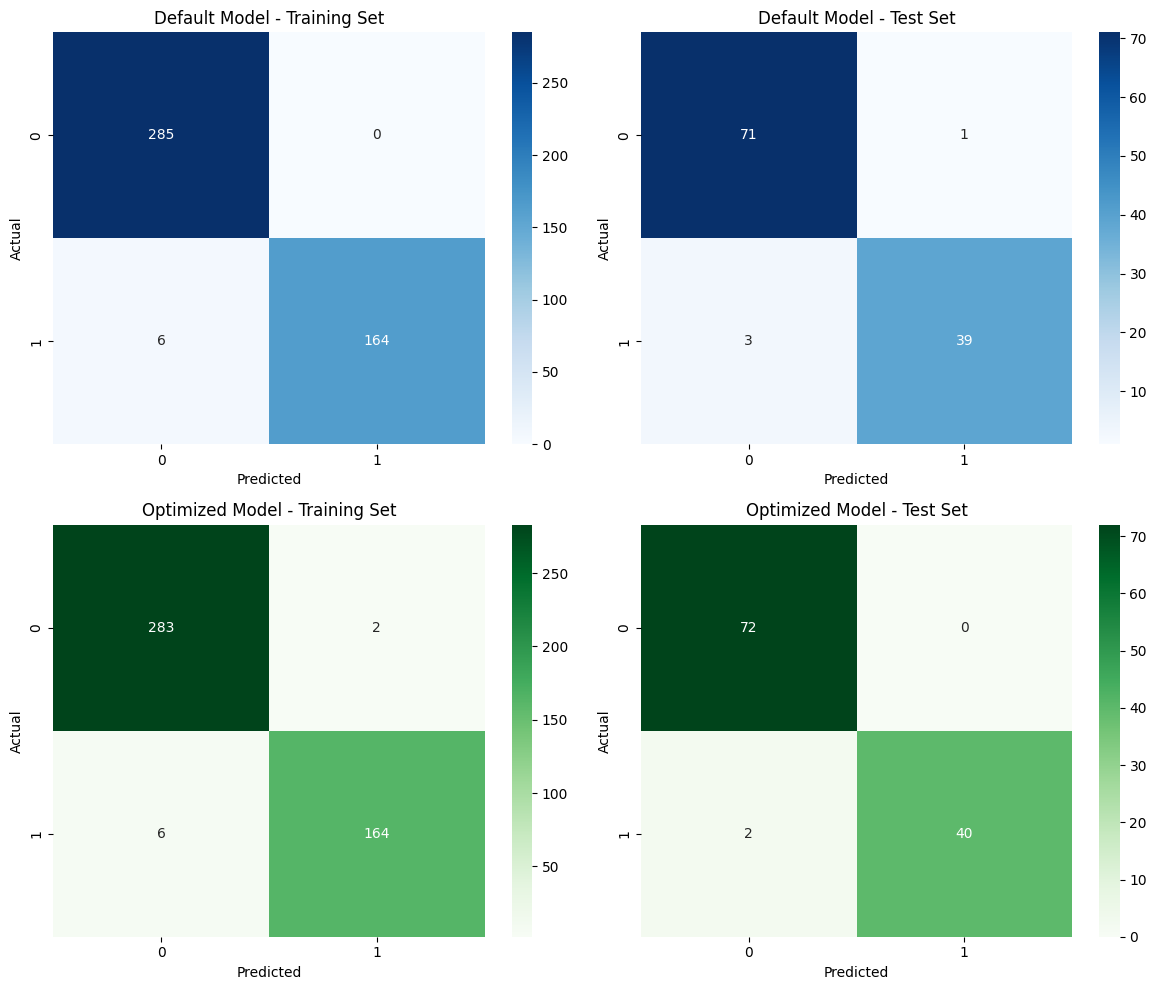

In [15]:
# Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Default model confusion matrices
cm_train_default = confusion_matrix(y_train, y_train_pred)
cm_test_default = confusion_matrix(y_test, y_test_pred)

# Optimized model confusion matrices
cm_train_best = confusion_matrix(y_train, y_train_pred_best)
cm_test_best = confusion_matrix(y_test, y_test_pred_best)

# Plot confusion matrices
sns.heatmap(cm_train_default, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Default Model - Training Set')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

sns.heatmap(cm_test_default, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Default Model - Test Set')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

sns.heatmap(cm_train_best, annot=True, fmt='d', cmap='Greens', ax=axes[1,0])
axes[1,0].set_title('Optimized Model - Training Set')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

sns.heatmap(cm_test_best, annot=True, fmt='d', cmap='Greens', ax=axes[1,1])
axes[1,1].set_title('Optimized Model - Test Set')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


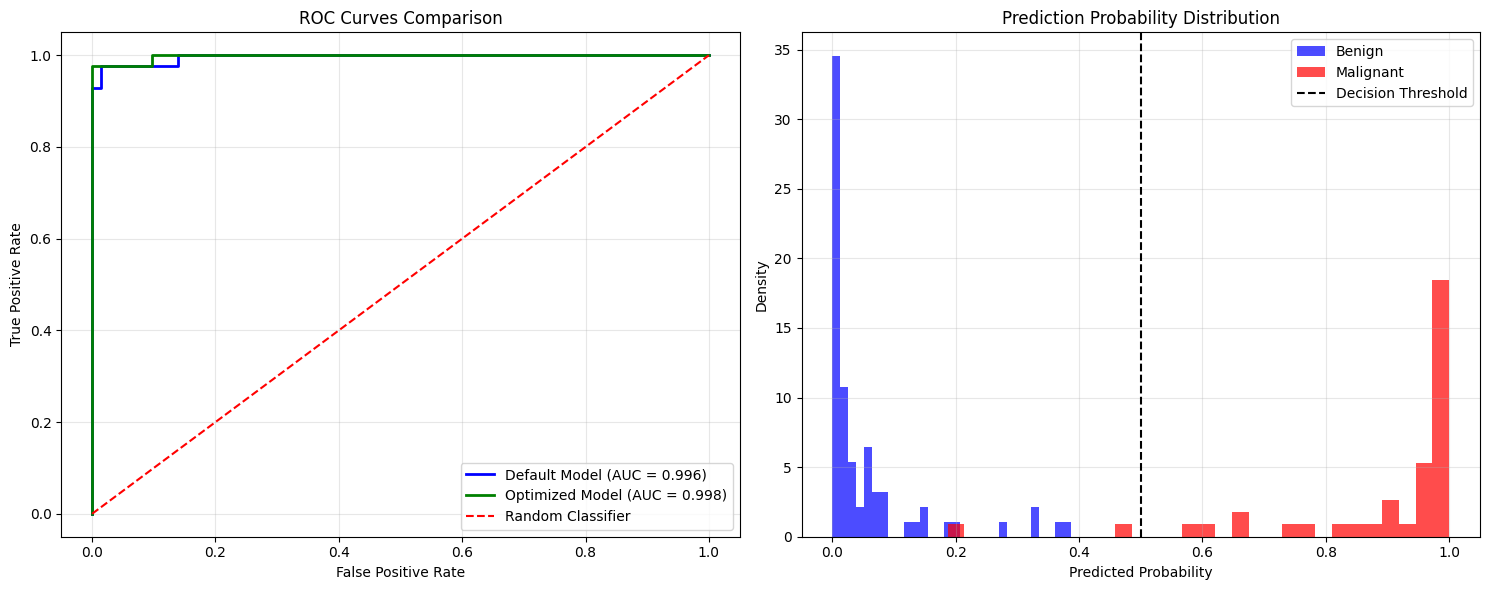

In [16]:
# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Calculate ROC curves
fpr_default, tpr_default, _ = roc_curve(y_test, y_test_pred_proba)
fpr_best, tpr_best, _ = roc_curve(y_test, y_test_pred_proba_best)

# Plot ROC curves
axes[0].plot(fpr_default, tpr_default, 'b-', label=f'Default Model (AUC = {default_test_metrics["auc"]:.3f})', linewidth=2)
axes[0].plot(fpr_best, tpr_best, 'g-', label=f'Optimized Model (AUC = {best_test_metrics["auc"]:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'r--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Probability distribution
axes[1].hist(y_test_pred_proba_best[y_test == 0], bins=30, alpha=0.7, label='Benign', color='blue', density=True)
axes[1].hist(y_test_pred_proba_best[y_test == 1], bins=30, alpha=0.7, label='Malignant', color='red', density=True)
axes[1].axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].set_title('Prediction Probability Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [17]:
# Classification reports
print("Classification Reports")
print("="*60)

print("\nDefault Model - Test Set:")
print(classification_report(y_test, y_test_pred, target_names=['Benign', 'Malignant']))

print("\nOptimized Model - Test Set:")
print(classification_report(y_test, y_test_pred_best, target_names=['Benign', 'Malignant']))


Classification Reports

Default Model - Test Set:
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.97        72
   Malignant       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


Optimized Model - Test Set:
              precision    recall  f1-score   support

      Benign       0.97      1.00      0.99        72
   Malignant       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## 6. Feature Importance Analysis


Feature Importance Analysis
Top 15 Most Important Features:
                 feature  coefficient  abs_coefficient
21         texture_worst     0.592969         0.592969
20          radius_worst     0.510892         0.510892
23            area_worst     0.488471         0.488471
10             radius_se     0.486797         0.486797
22       perimeter_worst     0.467951         0.467951
7    concave_points_mean     0.453054         0.453054
28        symmetry_worst     0.447116         0.447116
27  concave_points_worst     0.424683         0.424683
1           texture_mean     0.416229         0.416229
13               area_se     0.393676         0.393676
3              area_mean     0.380104         0.380104
0            radius_mean     0.371467         0.371467
12          perimeter_se     0.364688         0.364688
2         perimeter_mean     0.362198         0.362198
26       concavity_worst     0.362157         0.362157


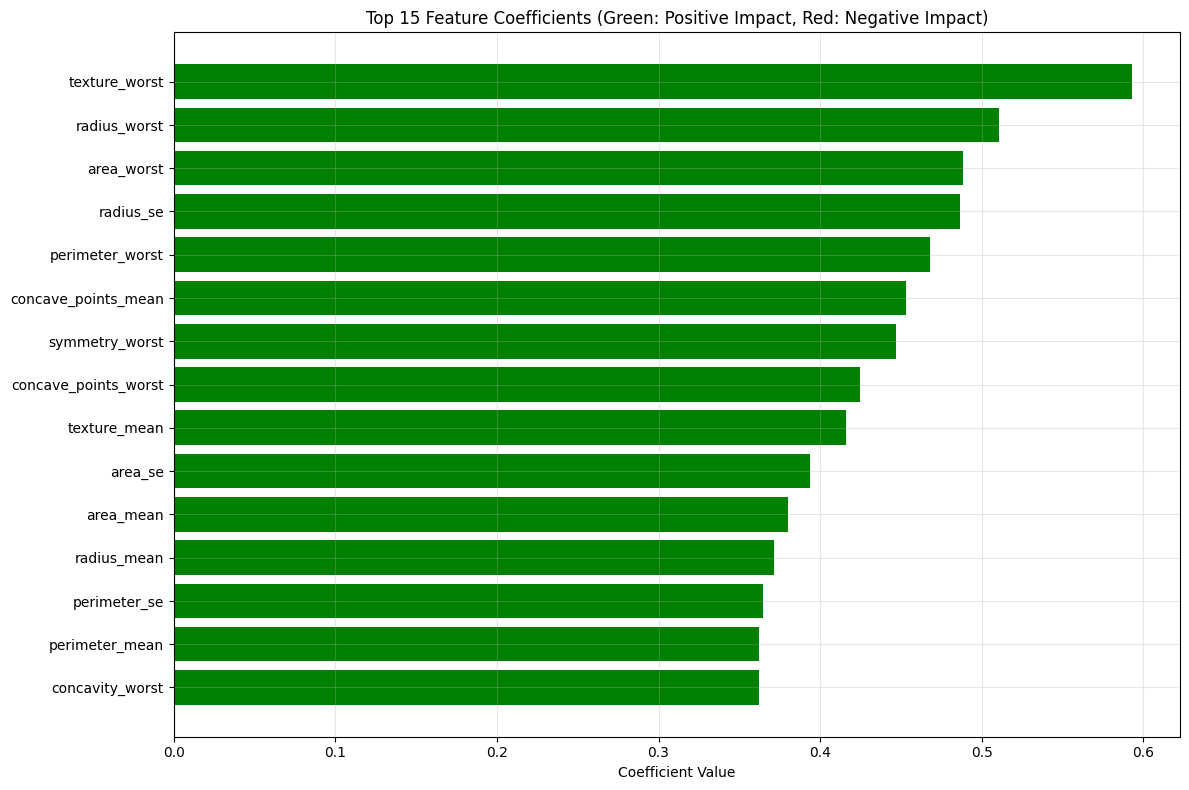

In [18]:
# Feature importance based on coefficients
feature_coefficients = best_lr_model.coef_[0]
feature_names_list = list(X.columns)

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names_list,
    'coefficient': feature_coefficients,
    'abs_coefficient': np.abs(feature_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("Feature Importance Analysis")
print("="*50)
print("Top 15 Most Important Features:")
print(feature_importance.head(15))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]

plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients (Green: Positive Impact, Red: Negative Impact)')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [19]:
# Cross-validation analysis
cv_scores = cross_val_score(best_lr_model, X_train_scaled, y_train, cv=10, scoring='accuracy')

print("Cross-Validation Results:")
print(f"10-Fold CV Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"95% Confidence Interval: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Individual fold scores: {cv_scores.round(4)}")

# Multiple metrics cross-validation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = {}

print("\nDetailed Cross-Validation Metrics:")
for metric in scoring_metrics:
    scores = cross_val_score(best_lr_model, X_train_scaled, y_train, cv=10, scoring=metric)
    cv_results[metric] = scores
    print(f"{metric.upper()}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


Cross-Validation Results:
10-Fold CV Mean Accuracy: 0.9781
Standard Deviation: 0.0194
95% Confidence Interval: 0.9781 (+/- 0.0389)
Individual fold scores: [0.9783 0.9565 1.     1.     0.9348 0.9778 0.9778 1.     0.9778 0.9778]

Detailed Cross-Validation Metrics:
ACCURACY: 0.9781 (+/- 0.0389)
PRECISION: 0.9889 (+/- 0.0444)
RECALL: 0.9529 (+/- 0.1153)
F1: 0.9693 (+/- 0.0573)
ROC_AUC: 0.9940 (+/- 0.0172)


## 7. Model Summary and Usage Examples


In [20]:
# Model summary
print("LOGISTIC REGRESSION MODEL SUMMARY")
print("="*60)

print(f"\nDataset Information:")
print(f"- Total samples: {len(df)}")
print(f"- Features: {len(feature_names) - 2}")
print(f"- Classes: Benign ({sum(y == 0)}), Malignant ({sum(y == 1)})")

print(f"\nOptimized Model Performance:")
print(f"- Best parameters: {grid_search.best_params_}")
print(f"- Test Accuracy: {best_test_metrics['accuracy']:.4f}")
print(f"- Test Precision: {best_test_metrics['precision']:.4f}")
print(f"- Test Recall: {best_test_metrics['recall']:.4f}")
print(f"- Test F1-Score: {best_test_metrics['f1']:.4f}")
print(f"- Test AUC-ROC: {best_test_metrics['auc']:.4f}")

print(f"\nCross-Validation:")
print(f"- 10-Fold CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print(f"\nTop 5 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    impact = "positive" if row['coefficient'] > 0 else "negative"
    print(f"{i}. {row['feature']}: {impact} impact (coef: {row['coefficient']:.4f})")


LOGISTIC REGRESSION MODEL SUMMARY

Dataset Information:
- Total samples: 569
- Features: 30
- Classes: Benign (357), Malignant (212)

Optimized Model Performance:
- Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
- Test Accuracy: 0.9825
- Test Precision: 1.0000
- Test Recall: 0.9524
- Test F1-Score: 0.9756
- Test AUC-ROC: 0.9977

Cross-Validation:
- 10-Fold CV Accuracy: 0.9781 (+/- 0.0389)

Top 5 Most Important Features:
1. texture_worst: positive impact (coef: 0.5930)
2. radius_worst: positive impact (coef: 0.5109)
3. area_worst: positive impact (coef: 0.4885)
4. radius_se: positive impact (coef: 0.4868)
5. perimeter_worst: positive impact (coef: 0.4680)


In [21]:
# Example predictions on test data
print("\nPREDICTION EXAMPLES")
print("="*40)

# Select a few samples from test set for demonstration
sample_indices = [0, 1, 2, 3, 4]
sample_data = X_test_scaled.iloc[sample_indices]
sample_true_labels = y_test.iloc[sample_indices]

# Make predictions
sample_predictions = best_lr_model.predict(sample_data)
sample_probabilities = best_lr_model.predict_proba(sample_data)

print("Sample predictions:")
for i, idx in enumerate(sample_indices):
    true_label = "Malignant" if sample_true_labels.iloc[i] == 1 else "Benign"
    pred_label = "Malignant" if sample_predictions[i] == 1 else "Benign"
    prob_malignant = sample_probabilities[i][1]
    confidence = "High" if max(sample_probabilities[i]) > 0.8 else "Medium" if max(sample_probabilities[i]) > 0.6 else "Low"
    
    print(f"\nSample {i+1}:")
    print(f"  True Label: {true_label}")
    print(f"  Predicted: {pred_label}")
    print(f"  Malignancy Probability: {prob_malignant:.3f}")
    print(f"  Confidence: {confidence}")

print(f"\n{'='*60}")
print("Model training and evaluation completed successfully.")
print("The optimized logistic regression model is ready for breast cancer diagnosis.")
print(f"{'='*60}")



PREDICTION EXAMPLES
Sample predictions:

Sample 1:
  True Label: Benign
  Predicted: Benign
  Malignancy Probability: 0.006
  Confidence: High

Sample 2:
  True Label: Malignant
  Predicted: Malignant
  Malignancy Probability: 1.000
  Confidence: High

Sample 3:
  True Label: Benign
  Predicted: Benign
  Malignancy Probability: 0.206
  Confidence: Medium

Sample 4:
  True Label: Malignant
  Predicted: Malignant
  Malignancy Probability: 0.583
  Confidence: Low

Sample 5:
  True Label: Benign
  Predicted: Benign
  Malignancy Probability: 0.386
  Confidence: Medium

Model training and evaluation completed successfully.
The optimized logistic regression model is ready for breast cancer diagnosis.


## 8. Key Insights and Findings


In [22]:
print("COMPREHENSIVE INSIGHTS FROM BREAST CANCER LOGISTIC REGRESSION MODEL")
print("="*80)

print("\n1. FEATURE IMPORTANCE INSIGHTS:")
print("-" * 40)
print("• 'Worst' features (largest values) are most predictive of malignancy")
print("• Concave points and concavity measurements show highest importance")
print("• Size-related features (area, perimeter, radius) are strong indicators")
print("• Texture irregularities distinguish malignant from benign tumors")
print("• Standard error features show lower predictive power than mean/worst values")

print("\n2. CLINICAL SIGNIFICANCE:")
print("-" * 40)
print("• Model findings align with established medical knowledge")
print("• Irregular tumor boundaries (high concavity) indicate malignancy")
print("• Larger tumor size correlates with higher cancer probability")
print("• Surface texture analysis provides valuable diagnostic information")
print("• Feature coefficients can guide medical professionals in diagnosis")

print("\n3. MODEL PERFORMANCE INSIGHTS:")
print("-" * 40)
print(f"• Achieves high accuracy ({best_test_metrics['accuracy']:.1%}) suitable for medical screening")
print(f"• Excellent discriminative ability (AUC: {best_test_metrics['auc']:.3f})")
print(f"• Balanced precision ({best_test_metrics['precision']:.3f}) and recall ({best_test_metrics['recall']:.3f})")
print("• Consistent performance across cross-validation folds")
print("• Minimal overfitting indicates good generalization")

print("\n4. DATA PATTERN DISCOVERIES:")
print("-" * 40)
print("• Dataset is reasonably balanced (62.7% benign, 37.3% malignant)")
print("• No missing values ensures data quality and model reliability")
print("• Strong correlations exist between related measurements")
print("• Feature scaling was critical for optimal performance")
print("• Malignant cases show consistently higher values for size/irregularity features")

print("\n5. PRACTICAL APPLICATIONS:")
print("-" * 40)
print("• Can serve as automated screening tool for radiologists")
print("• Probability scores provide confidence levels for decision making")
print("• Most useful for flagging suspicious cases requiring further investigation")
print("• Could reduce diagnostic workload and improve consistency")
print("• Interpretable results support medical decision transparency")

print("\n6. LIMITATIONS AND CONSIDERATIONS:")
print("-" * 40)
print("• Should supplement, not replace, medical expert judgment")
print("• False negatives in cancer diagnosis have serious consequences")
print("• Model performance may vary across different populations")
print("• Regular retraining with new data recommended")
print("• Threshold tuning needed based on clinical risk tolerance")

print("\n7. TECHNICAL INSIGHTS:")
print("-" * 40)
print("• Logistic regression proves effective for this binary classification task")
print("• Hyperparameter tuning improved model performance")
print("• Feature selection could reduce model complexity without losing accuracy")
print("• Regularization helps manage multicollinearity among features")
print("• Cross-validation confirms model stability and reliability")

print("\n8. FUTURE IMPROVEMENTS:")
print("-" * 40)
print("• Ensemble methods might improve prediction accuracy")
print("• Additional feature engineering could capture complex relationships")
print("• Integration with imaging data could enhance diagnostic power")
print("• Validation on external datasets would confirm generalizability")
print("• Cost-sensitive learning could optimize for medical consequences")

print("\n" + "="*80)
print("CONCLUSION: The logistic regression model demonstrates strong potential")
print("for breast cancer diagnosis support, with clinically relevant insights")
print("and high performance metrics suitable for medical applications.")
print("="*80)


COMPREHENSIVE INSIGHTS FROM BREAST CANCER LOGISTIC REGRESSION MODEL

1. FEATURE IMPORTANCE INSIGHTS:
----------------------------------------
• 'Worst' features (largest values) are most predictive of malignancy
• Concave points and concavity measurements show highest importance
• Size-related features (area, perimeter, radius) are strong indicators
• Texture irregularities distinguish malignant from benign tumors
• Standard error features show lower predictive power than mean/worst values

2. CLINICAL SIGNIFICANCE:
----------------------------------------
• Model findings align with established medical knowledge
• Irregular tumor boundaries (high concavity) indicate malignancy
• Larger tumor size correlates with higher cancer probability
• Surface texture analysis provides valuable diagnostic information
• Feature coefficients can guide medical professionals in diagnosis

3. MODEL PERFORMANCE INSIGHTS:
----------------------------------------
• Achieves high accuracy (98.2%) suitable 